#### authors: Rafael Dousse, Eva Ray, Massimo Stefani

# PW4 - Linear Regression

## Imports

In [24]:
import random
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

## Load data

Define the path to the file containing the data

In [25]:
datafile = "lausanne-appart.csv"

Read the data

In [26]:
dataset = pd.read_csv(datafile)

Display first rows

In [27]:
dataset.head()

,living_area,nb_rooms,rent_price
0,69,3.0,1810
1,95,3.5,2945
2,21,1.5,685
3,20,1.0,720
4,33,1.5,830


## Exercise 1 - Visualize the data

a) Plot a histogram to visualize the distribution of the renting price

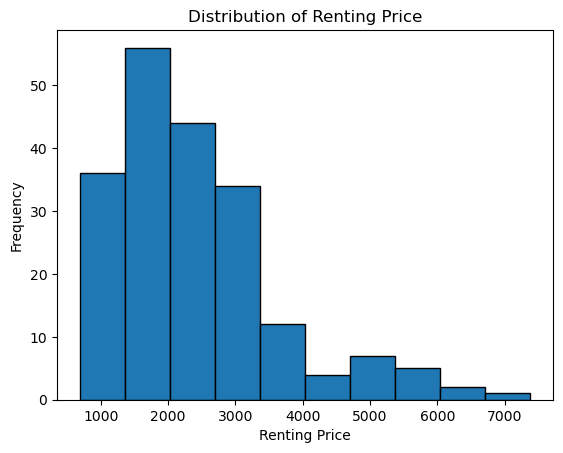

In [28]:
# Your code here
plt.hist(dataset['rent_price'], edgecolor='black')
plt.title('Distribution of Renting Price')
plt.xlabel('Renting Price')
plt.ylabel('Frequency')
plt.show()

b) Plot a histogram to visualize the distribution of the living area

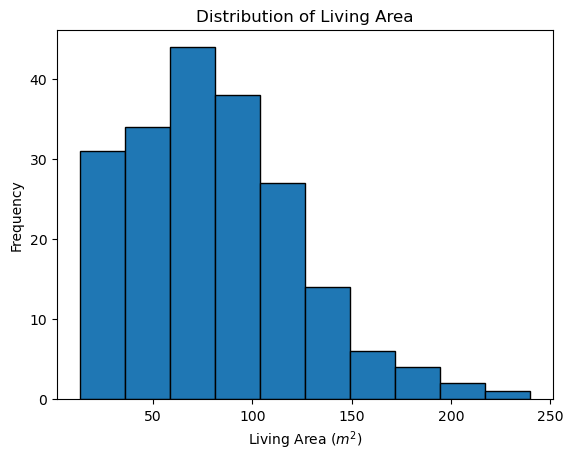

In [29]:
# Your code here
plt.hist(dataset['living_area'], edgecolor='black')
plt.title('Distribution of Living Area')
plt.xlabel('Living Area ($m^2$)')
plt.ylabel('Frequency')
plt.show()

c) Plot a scatter plot of renting price as a function of living area

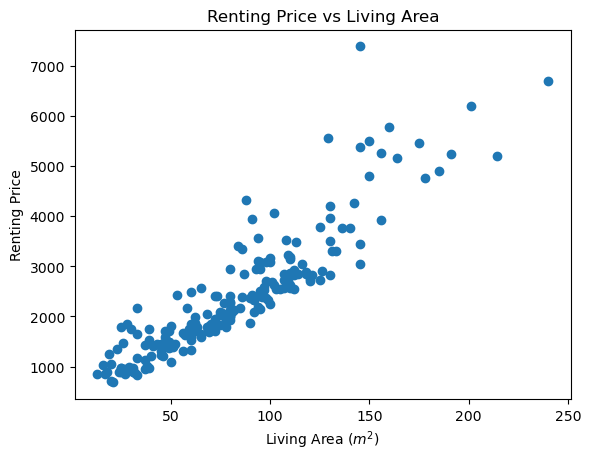

In [30]:
# Your code here
plt.scatter(dataset['living_area'], dataset['rent_price'])
plt.title('Renting Price vs Living Area')
plt.xlabel('Living Area ($m^2$)')
plt.ylabel('Renting Price')
plt.show()

## Exercise 2 - Normal equations for linear regression

a) Implement the closed form solution to this problem using the following normal equation:

$\theta = (X^{T}X)^{-1}X^{T}\vec{y}$

In [61]:

X = dataset[['living_area', 'nb_rooms']].to_numpy(dtype=float)
y = dataset['rent_price'].to_numpy(dtype=float)

# The first column of X must be all ones
ones = np.ones((X.shape[0], 1))
X = np.hstack((ones, X))

theta_i = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
# apparently, it's better and more stable to use pinv (or even solve() or lstsq() instead of inv)
theta_pi = np.dot(np.linalg.pinv(X), y)

print("Theta (using inv):", theta_i)
print("Theta (using pinv):", theta_pi)

Theta (using inv): [286.93086826  28.66118876 -76.06313749]
Theta (using pinv): [286.93086826  28.66118876 -76.06313749]


Assuming $x$ is the living area and $y$ is the renting price. Use `numpy` for the vector operations. Plot the computed line on top of the scatter plot of exercise 1.

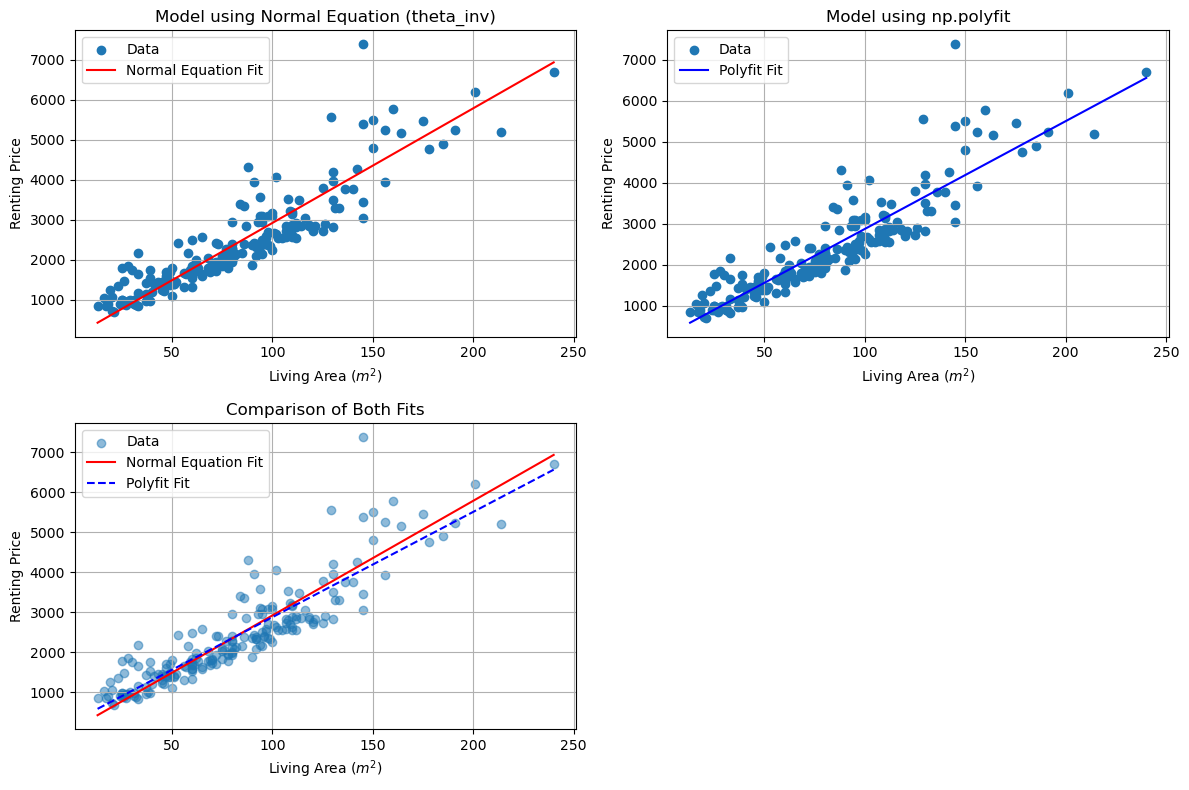

In [62]:
# we generate points between min and max of living_area for plotting the regression line
x_line = np.linspace(dataset['living_area'].min(), dataset['living_area'].max(), 200)
# here we create a constant array for nb_rooms, using the mean of the dataset
rooms_const = np.full_like(x_line, dataset['nb_rooms'].mean())
# Then we create the matrix with the same structure as X for prediction
X_line = np.column_stack([np.ones_like(x_line), x_line, rooms_const])
# Now we can compute the predicted y values using our model
y_line = X_line.dot(theta_i)

# We also compute the poly fit for comparison
coeffs = np.polyfit(dataset['living_area'], dataset['rent_price'], 1)
model = np.poly1d(coeffs)
y_polyfit = model(x_line)

# We create a 2x2 subplot grid to compare the two models
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
(ax1, ax2), (ax3, _) = axs 

# First subplot using Normal Equation
ax1.scatter(dataset['living_area'], dataset['rent_price'], label="Data")
ax1.plot(x_line, y_line, color='red', label="Normal Equation Fit")
ax1.set_title('Model using Normal Equation (theta_inv)')
ax1.set_xlabel('Living Area ($m^2$)')
ax1.set_ylabel('Renting Price')
ax1.legend()
ax1.grid(True)

# Second subplot using Polyfit
ax2.scatter(dataset['living_area'], dataset['rent_price'], label="Data")
ax2.plot(x_line, y_polyfit, color='blue', label="Polyfit Fit")
ax2.set_title('Model using np.polyfit')
ax2.set_xlabel('Living Area ($m^2$)')
ax2.set_ylabel('Renting Price')
ax2.legend()
ax2.grid(True)

# Third subplot comparing both models on the same plot
ax3.scatter(dataset['living_area'], dataset['rent_price'], alpha=0.5, label="Data")
ax3.plot(x_line, y_line, color='red', label="Normal Equation Fit")
ax3.plot(x_line, y_polyfit, color='blue', linestyle='--', label="Polyfit Fit")
ax3.set_title('Comparison of Both Fits')
ax3.set_xlabel('Living Area ($m^2$)')
ax3.set_ylabel('Renting Price')
ax3.legend()
ax3.grid(True)

# we don't need the fourth subplot, so we remove it
fig.delaxes(axs[1, 1])

# Finally, we can adjust layout and show the plots
plt.tight_layout()
plt.show()


__*We have almost the same line but not exactly and I am not sure why?*__

b) Compute the overall cost value according to the following equation:

$J(\theta) = \frac{1}{2N} \sum_{n=1}^{N} (h_{\theta}(\mathbf{x}_{n}) - y_{n})^{2}$ 
$(2)$

In [72]:
# Your code here


def cost_function(X, y, theta):
    N = X.shape[0]
    y_pred = X.dot(theta)
    J = (1/(2*N)) * np.sum((y_pred - y)**2)
    return J
J_theta = cost_function(X, y, theta_i)
print("Cost function J(theta) =", J_theta)

Cost function J(theta) = 136966.11624670407


## Exercise 3 - Gradient descent for linear regression

Implement the _full batch_ gradient descent algorithm for the previous problem. As seen in the
theory, the update rules are:

<div><div style="display: table-cell; width: 100%;"><center>$\theta_{0} \leftarrow \theta_{0} - \alpha \frac{1}{N} \sum_{n=1}^{N} (h_{\theta}(\mathbf{x}_{n}) - y_{n})$</center></div><div style="display: table-cell; width: 100%;">$(6)$</div></div>

<div><div style="display: table-cell; width: 100%;"><center>$\theta_{1} \leftarrow \theta_{1} - \alpha \frac{1}{N} \sum_{n=1}^{N} (h_{\theta}(\mathbf{x}_{n}) - y_{n}) x_{n,1}$</center></div><div style="display: table-cell; width: 100%;">$(7)$</div></div>

**Remark** You need to iterate several times over the training set. If you have problems of convergence, you need to use a smaller value of $\alpha$. Values such as $0.000001$ are common.

In [10]:
# Your code here

a) Plot the cost value (Equation 2) as a function of the iterations. What do you observe?

In [11]:
# Your code here

_Your answer here_

b) Imagine a stopping criterion, i.e. when do we stop iterating on the training set?

_Your answer here_

c) Plot the computed line $h_{\theta}(\mathbf{x})$ on top of the scatter plot of exercise 1.

In [12]:
# Your code here

d) Compute the final cost value according to Equation 2 and compare it to the one of exercise 2. What can you conclude?

In [13]:
# Your code here

_Your answer here_

## Exercise 4 - Stochastic gradient descent for linear regression

Implement the stochastic gradient descent algorithm for the previous problem. As seen in the theory, the update rules are:

<div><div style="display: table-cell; width: 100%;"><center>$\theta_{i} \leftarrow \theta_{i} - \alpha (h_{\theta}(\mathbf{x}_{n}) - y_{n}) x_{n,i}$</center></div><div style="display: table-cell; width: 100%;">$(8)$</div></div>

In [14]:
# Your code here

a) Plot the computed line $h_{\theta}(\mathbf{x})$ on top of the scatter plot of exercise 1.

In [15]:
# Your code here

b) How many samples do you need to visit for reaching the convergence?

_Your answer here_

c) What kind of stopping criterion could we use here?

_Your answer here_

d) Compute the final cost value according to Equation 2 and compare it to the one of exercise 2 and 3. What can you conclude?

In [16]:
# Your code here

_Your answer here_

## Exercise 5 - Review questions

a) The linear regression has a mathematical _closed form_ solution. Then, in which conditions would we prefer a gradient descent algorithm to compute the regression model?

_Your answer here_

b) Outliers in a data set can be defined as values that are out of the "usual" range in comparison with other values. They typically come from noise or anomalies in the data capturing process. What is the impact of an outlier in the stochastic gradient descent process? What if we have many outliers? _Hint_: look at the equation of the MSE, and to the equation of the update rule.

_Your answer here_

c) In the case of stochastic gradient descent, what is the danger of having a too large or too small $\alpha$ value? Could you think of a better (more advanced) strategy as the one stated in Slide 36?

_Your answer here_

d) Let's assume we expect that the target variable $y$ has a dependency to the square and to the cube of one of the feature $x_d$ in our multi-variable training set $(x_1, \ldots, x_d, \ldots, x_D)$. How would you proceed? Do we need to take precautions in terms of numerical stability?

_Your answer here_

e) _Advanced_. Could we use a descent algorithm without computing the gradient? If yes, give a pseudo code of the algorithm to find $(\theta_{0}, \theta_{1})$ using a linear regression $h_{\theta}(x) = \theta_0 + \theta_1 x$.

_Your answer here_

# Exercise 7 - Multi-variable linear regression

__a)__ Implement one of the gradient descent algorithm (ex. 3-5) for the multi-variable linear
regression assuming x1 being the living area and x2 the square of the living area. Plot the
computed curve (second order) on top of the scatter plot of exercise 1. Do you observe
a reduction in the loss ?

In [95]:
def normalize(X):
    """
    Normalize the features in X to have mean 0 and standard deviation 1.
    
    X: numpy array of shape (m, n)
    Return: Tuple (X_norm, means, stds)
    """
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    X_norm = (X - means) / stds
    return X_norm, means, stds


def batch_gd(X_with_bias, y, alpha=0.1, iters=1000):
    """Batch gradient descent pour d features (biais inclus dans X)."""
    N, D = X_with_bias.shape
    theta = np.zeros(D)
    history = []
    for t in range(iters):
        y_pred = X_with_bias.dot(theta)
        grad = (X_with_bias.T.dot(y_pred - y)) / N
        theta -= alpha * grad
        history.append(cost_function(X_with_bias, y, theta))
    return theta, history



In [ ]:
x = dataset['living_area'].to_numpy(dtype=float)
y = dataset['rent_price'].to_numpy(dtype=float)

X_raw = np.column_stack((x, x**2))
X_normalized, means, stds = normalize(X_raw)
X_normalized = np.column_stack((np.ones((X_normalized.shape[0], 1)), X_normalized))



In [77]:
alpha = 0.01
num_iters = 1000
theta_poly, history = batch_gd(X_normalized, y, alpha, num_iters)
print("Theta (polynomial):", theta_poly)
print("Final cost (polynomial):", history[-1])

Theta (polynomial): [2378.14110934  658.53240819  468.460363  ]
Final cost (polynomial): 134922.01723439965


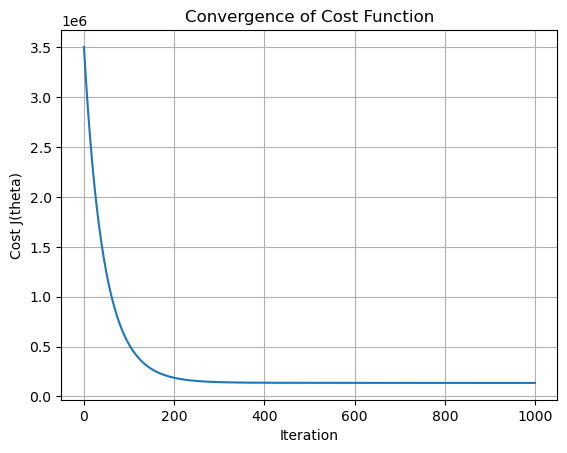

In [79]:
# Draw the convergence graph
plt.plot(history)
plt.title('Convergence of Cost Function')
plt.xlabel('Iteration')
plt.ylabel('Cost J(theta)')
plt.grid(True)
plt.show()

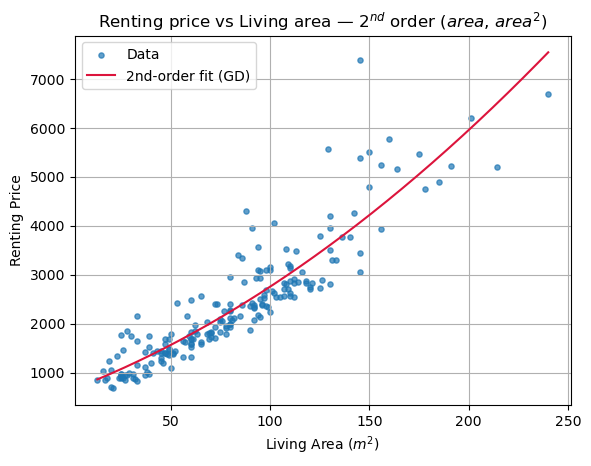

In [ ]:
# Draw the polynomial fit
x_line = np.linspace(x.min(), x.max(), 300)
X_line_raw = np.column_stack([x_line, x_line**2])
X_line_norm = (X_line_raw - means) / stds
X_line_bias = np.column_stack([np.ones(X_line_norm.shape[0]), X_line_norm])
y_pred = X_line_bias.dot(theta_poly)


plt.scatter(x, y, s=14, alpha=0.7, label="Data")
plt.plot(x_line, y_pred, color="crimson", label="2nd-order fit (GD)")
plt.title("Renting price vs Living area — $2^{nd}$ order ($area$, $area^2$)")
plt.xlabel("Living Area ($m^2$)")
plt.ylabel("Renting Price")
plt.legend()
plt.grid(True)
plt.show()

**b)** Implement one of the gradient descent algorithm (ex. 3-5) for the multi-variable linear
regression assuming x1 being the living area and x2 the number of bedrooms. Do you
observe a reduction in the loss ?

In [103]:
x1 = dataset["living_area"].to_numpy(dtype=float)
x2 = dataset["nb_rooms"].to_numpy(dtype=float)
y  = dataset["rent_price"].to_numpy(dtype=float)

X_raw = np.column_stack([x1, x2])
Xn, means2, stds2 = normalize(X_raw)
Xn_bias = np.column_stack([np.ones(Xn.shape[0]), Xn])


In [108]:
alpha = 0.01
num_iters = 1000

theta_pol2, history2 = batch_gd(Xn_bias, y, alpha, num_iters)
print("Theta (polynomial):", theta_poly)
print("Final cost (polynomial):", history2[-1])

Theta (polynomial): [2378.14110934  658.53240819  468.460363  ]
Final cost (polynomial): 143152.18724112117


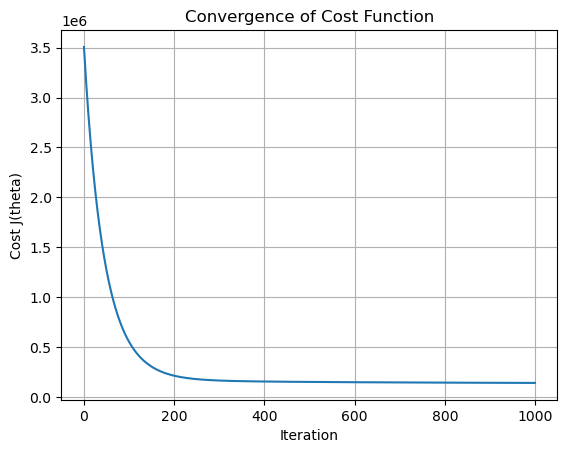

In [109]:
# Draw the convergence graph
plt.plot(history2)
plt.title('Convergence of Cost Function')
plt.xlabel('Iteration')
plt.ylabel('Cost J(theta)')
plt.grid(True)
plt.show()

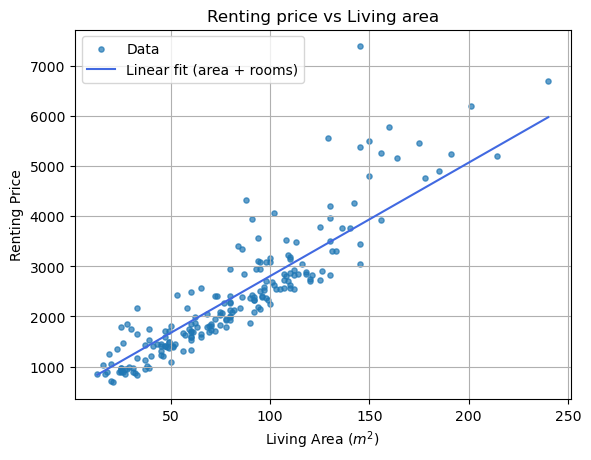

In [110]:
# Draw the multivariate linear fit
x_line = np.linspace(x1.min(), x1.max(), 300)
rooms_const = np.full_like(x_line, x2.mean())
X_line_raw = np.column_stack([x_line, rooms_const])
X_line_n = (X_line_raw - means2) / stds2
X_line_bias = np.column_stack([np.ones(X_line_n.shape[0]), X_line_n])
y_pred = X_line_bias.dot(theta_pol2)

plt.scatter(x1, y, s=14, alpha=0.7, label="Data")
plt.plot(x_line, y_pred, color="royalblue", label="Linear fit (area + rooms)")
plt.title("Renting price vs Living area")
plt.xlabel("Living Area ($m^2$)")
plt.ylabel("Renting Price")
plt.legend()
plt.grid(True)
plt.show()